In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load images

In [5]:
folderimages_scaled = '/home/perez/CompuTools/Direct-Detection/new/out-images-scaled-cv/'

model_name = 'saved-models/model_CNN_75x75_500GeV_cv_v3.h5'
model_paper = 'paper-model/final_model.h5'

In [6]:
from keras import backend as K
np.random.seed(0)

# Define recall, precision and f1 functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##### TEST-VAL SET

In [7]:
# test
from PIL import Image

for i in range(2):
    img = Image.open( folderimages_scaled+'WP' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print(data.shape)
    
for i in range(2):
    img = Image.open( folderimages_scaled+'ER' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print(data.shape)

(75, 75, 4)
(75, 75, 4)
(75, 75, 4)
(75, 75, 4)


In [9]:
##########
# SIGNAL #
##########
num_signal = 5000

file_pathsWP = glob.glob(path.join(folderimages_scaled, 'WP*.png'))

# Load the images into a single variable and convert to a numpy array
imagesWP = [imageio.imread(file_pathsWP[jj]) for jj in range(num_signal)]
imagesWP = np.asarray(imagesWP)

labelsWP = np.ones(num_signal)


##############
# BACKGROUND #
##############
num_back = 5000

file_pathsER = glob.glob(path.join(folderimages_scaled, 'ER*.png'))

# Load the images into a single variable and convert to a numpy array
imagesER = [imageio.imread(file_pathsER[jj]) for jj in range(num_back)]
imagesER = np.asarray(imagesER)

labelsER = np.zeros(num_back)



images = np.concatenate([imagesWP,imagesER])
del imagesWP
del imagesER

labels = np.concatenate([labelsWP,labelsER])
del labelsWP
del labelsER



print('images.shape: ', images.shape)
print('labels.shape: ', labels.shape)

# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

# Scale images so values are between 0 and 1
images = images / 255

n_images = images.shape[0]

images.shape:  (10000, 75, 75, 4)
labels.shape:  (10000,)
[75 75  4]


In [10]:
sum(labels)

5000.0

In [11]:
labels.shape

(10000,)

In [29]:
# file_paths = glob.glob(path.join(folderimages_scaled, '*.png'))

# # Load the images into a single variable and convert to a numpy array
# images = [imageio.imread(file_paths[jj]) for jj in range(20000)]
# images = np.asarray(images)
# print(images.shape)

# # Get image size
# image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
# print(image_size)

# # Scale images so values are between 0 and 1
# images = images / 255

In [26]:
# # Read the labels from the filenames

# n_images = images.shape[0]
# labels = np.zeros(n_images)
# for i in range(n_images):
#     filename = path.basename(file_paths[i])[0]
#     if filename[0] == 'W':                          #Every file that begins with W is assigned a 1
#         labels[i] = 1
#     else:
#         labels[i] = 0

# # Background = 0 = FALSE
# # WIMPS = 1 = TRUE

In [12]:
# Split into test and training sets

TRAIN_TEST_SPLIT = 0.7            

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_val = images[test_indices, :, :, :]
y_val = labels[test_indices]

#x_train = images
#y_train = labels

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(7000, 75, 75, 4)
(7000,)
(3000, 75, 75, 4)
(3000,)


##### TRAIN THE MODEL

In [13]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (image_size[0], image_size[1], image_size[2])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=1, validation_data=(x_val, y_val))
    model.save(model_name)
    #model.save_weights('final_weights.h5')
    score = model.evaluate(x_val, y_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
70/70 [==============================] - 23s 330ms/step - loss: 1.3270 - acc: 0.5137 - f1_m: 0.5113 - precision_m: 0.4968 - recall_m: 0.5553 - val_loss: 0.7736 - val_acc: 0.6070 - val_f1_m: 0.7204 - val_precision_m: 0.5655 - val_recall_m: 0.9953
Epoch 2/50
70/70 [==============================] - 23s 322ms/step - loss: 0.7502 - acc: 0.6293 - f1_m: 0.6099 - precision_m: 0.6333 - recall_m: 0.6231 - val_loss: 0.6204 - val_acc: 0.7503 - val_f1_m: 0.7776 - val_precision_m: 0.7113 - val_recall_m: 0.8591
Epoch 3/50
70/70 [==============================] - 23s 327ms/step - loss: 0.6494 - acc: 0.7260 - f1_m: 0.7153 - precision_m: 0.7326 - recall_m: 0.7155 - val_loss: 0.5762 - val_acc: 0.7830 - val_f1_m: 0.7980 - val_precision_m: 0.7589 - val_recall_m: 0.8428
Epoch 4/50
70/70 [==============================] - 23s 324ms/step - loss: 0.5924 - acc: 0.7646 - f1_m: 0.7631 - precision_m: 0.7583 - recall_m: 0.7761 - val_loss: 0.5508 - val_acc: 0.7890 - val_f1_m: 0.7797 - val_precision_m: 0.

Epoch 33/50
70/70 [==============================] - 26s 368ms/step - loss: 0.4813 - acc: 0.8430 - f1_m: 0.8405 - precision_m: 0.8441 - recall_m: 0.8423 - val_loss: 0.5072 - val_acc: 0.8310 - val_f1_m: 0.8356 - val_precision_m: 0.8257 - val_recall_m: 0.8478
Epoch 34/50
70/70 [==============================] - 26s 365ms/step - loss: 0.4753 - acc: 0.8431 - f1_m: 0.8393 - precision_m: 0.8446 - recall_m: 0.8402 - val_loss: 0.5080 - val_acc: 0.8270 - val_f1_m: 0.8377 - val_precision_m: 0.8016 - val_recall_m: 0.8792
Epoch 35/50
70/70 [==============================] - 24s 347ms/step - loss: 0.4729 - acc: 0.8479 - f1_m: 0.8463 - precision_m: 0.8438 - recall_m: 0.8531 - val_loss: 0.5157 - val_acc: 0.8180 - val_f1_m: 0.8093 - val_precision_m: 0.8640 - val_recall_m: 0.7629
Epoch 36/50
70/70 [==============================] - 25s 352ms/step - loss: 0.4680 - acc: 0.8501 - f1_m: 0.8475 - precision_m: 0.8505 - recall_m: 0.8497 - val_loss: 0.5134 - val_acc: 0.8317 - val_f1_m: 0.8418 - val_precision_m

##### TESTSET

In [64]:
# ############
# # TEST SET #
# ############

# file_paths = glob.glob(path.join(folderimages_scaled, '*.png'))

# # Load the images into a single variable and convert to a numpy array
# images_test = [imageio.imread(file_paths[jj]) for jj in range(10000,20000)]
# images_test = np.asarray(images_test)
# print(images_test.shape)

# # Get image size
# image_size = np.asarray([images_test.shape[1], images_test.shape[2], images_test.shape[3]])
# print(image_size)

# # Scale images so values are between 0 and 1
# images_test = images_test / 255


# # Read the labels from the filenames

# n_images_test = images_test.shape[0]
# labels_test = np.zeros(n_images_test)
# for i in range(n_images_test):
#     filename = path.basename(file_paths[10000+i])[0]     # STARTS AT THE END OF THE OTHER (TO ASSIGN CORRECT LABELS)
#     if filename[0] == 'W':                          #Every file that begins with W is assigned a 1
#         labels_test[i] = 1
#     else:
#         labels_test[i] = 0
        
        
        
# x_test = images_test
# y_test = labels_test

(10000, 75, 75, 4)
[75 75  4]


In [8]:
##########
# SIGNAL #
##########
num_signal = 10000
num_signal_test = 5000

file_pathsWP = glob.glob(path.join(folderimages_scaled, 'WP*.png'))

# Load the images into a single variable and convert to a numpy array
imagesWP = [imageio.imread(file_pathsWP[jj]) for jj in range(num_signal,num_signal+num_signal_test)]
imagesWP = np.asarray(imagesWP)

labelsWP = np.ones(num_signal_test)


##############
# BACKGROUND #
##############
num_back = 10000
num_back_test = 5000

file_pathsER = glob.glob(path.join(folderimages_scaled, 'ER*.png'))

# Load the images into a single variable and convert to a numpy array
imagesER = [imageio.imread(file_pathsER[jj]) for jj in range(num_back,num_back+num_back_test)]
imagesER = np.asarray(imagesER)

labelsER = np.zeros(num_back_test)



images_test = np.concatenate([imagesWP,imagesER])
del imagesWP
del imagesER

labels_test = np.concatenate([labelsWP,labelsER])
del labelsWP
del labelsER


print('images_test.shape: ', images_test.shape)
print('labels_test.shape: ', labels_test.shape)

# Get image size
image_size_test = np.asarray([images_test.shape[1], images_test.shape[2], images_test.shape[3]])
print(image_size_test)

# Scale images so values are between 0 and 1
images_test = images_test / 255

n_images_test = images_test.shape[0]



x_test = images_test
del images_test

y_test = labels_test
del labels_test

images_test.shape:  (10000, 75, 75, 4)
labels_test.shape:  (10000,)
[75 75  4]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 16)        592       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2654240   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

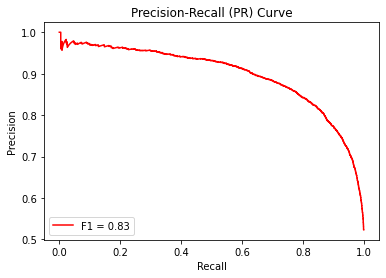

Accuracy: 0.8292
Average precision: 0.767109118426031
recall: 0.8578
AUC:0.8701442867953083
Predicted   0.0   1.0
Actual               
0.0        4003   997
1.0         711  4289


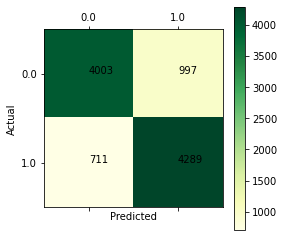

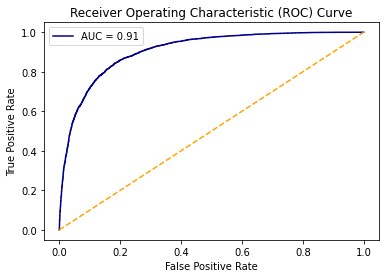

ROC AUC:  0.90686016


In [9]:
##########################
# TEST WITH THE TEST SET #
##########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_name, custom_objects=dependencies)

model.summary()



score = model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict_proba(x_test)    # Predict probabilities
yhat = model.predict(x_test)      # Predict class values
yhat_original = yhat
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test, yhat_original)
auc = auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 16)        592       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 72, 72, 16)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 72, 72, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 82944)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2654240   
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32)              

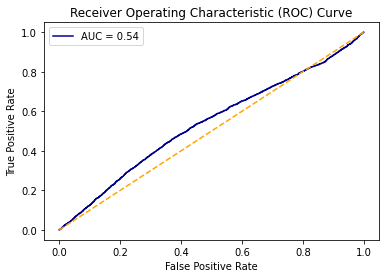

ROC AUC:  0.5379004


In [10]:
###############
# PAPER MODEL #
###############

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_paper, custom_objects=dependencies)

model.summary()


from sklearn.metrics import roc_curve, roc_auc_score, auc

yhat = model.predict(x_test)      # Predict class values
fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

##### Test with the train set (just to see)

In [14]:
##################################
# USING TO TEST THE TRAINING SET # THIS IS WRONG! but to see
##################################

x_test2 = images
del images

y_test2 = labels
del labels

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 16)        592       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2654240   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

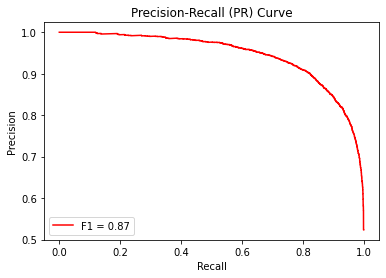

Accuracy: 0.8679
Average precision: 0.8118562653562653
recall: 0.897
AUC:0.8980829238329239
Predicted   0.0   1.0
Actual               
0.0        4194   806
1.0         515  4485


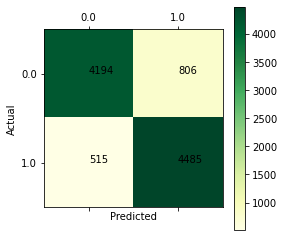

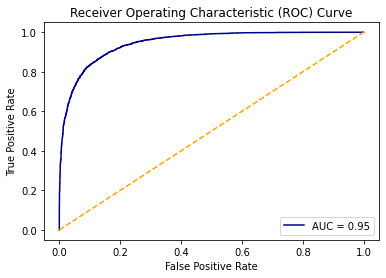

ROC AUC:  0.9460862400000001


In [15]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_name, custom_objects=dependencies)

model.summary()



score = model.evaluate(x_test2, y_test2, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict_proba(x_test2)    # Predict probabilities
yhat = model.predict(x_test2)      # Predict class values
yhat_original = yhat
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test2, lr_probs)
lr_f1, lr_auc = f1_score(y_test2, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_test2[y_test2==1]) / len(y_test2)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test2, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test2, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test2, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_test2, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test2.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test2, yhat_original)
auc = auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 16)        592       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 72, 72, 16)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 72, 72, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 82944)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2654240   
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32)              

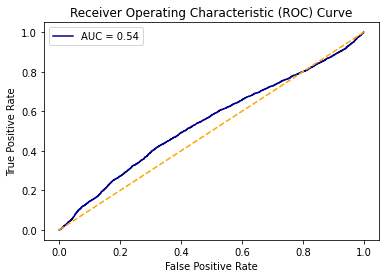

ROC AUC:  0.54449536


In [16]:
###############
# PAPER MODEL #
###############

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_paper, custom_objects=dependencies)

model.summary()


from sklearn.metrics import roc_curve, roc_auc_score, auc

yhat2 = model.predict(x_test2)      # Predict class values
fpr, tpr, thresholds = roc_curve(y_test2, yhat2)
auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)